In [2]:
import pandas as pd
from PIL import Image
import collections
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,DenseNet121,VGG16,InceptionV3,MobileNetV2,EfficientNetV2B0
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from random import randint



Module 1 : Data Loading and class distribution

First 5 entries in CSV:
      Classes                                              files
0    wrinkles  C:\Users\lenovo\PakhiSharma_AI_DermalScan\data...
1  puffy_eyes  C:\Users\lenovo\PakhiSharma_AI_DermalScan\data...
2    wrinkles  C:\Users\lenovo\PakhiSharma_AI_DermalScan\data...
3  puffy_eyes  C:\Users\lenovo\PakhiSharma_AI_DermalScan\data...
4  clear_face  C:\Users\lenovo\PakhiSharma_AI_DermalScan\data...

 Data loading and labeling done.

--- Class Distribution ---
Class: 'wrinkles', Images: 100
Class: 'puffy_eyes', Images: 101
Class: 'clear_face', Images: 97
Class: 'darkspots', Images: 102


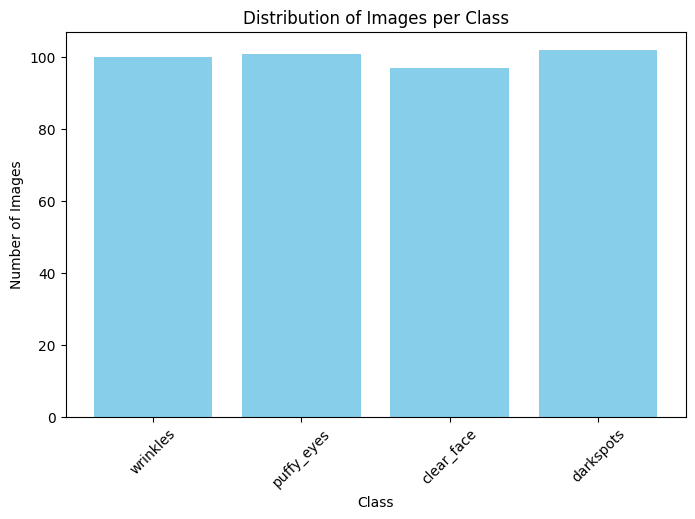

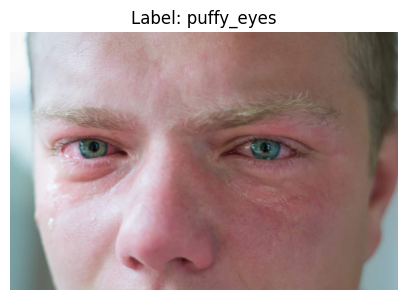

In [3]:
# Load CSV
csv_file = r"C:\Users\lenovo\PakhiSharma_AI_DermalScan\datasets\face_images.csv"
df = pd.read_csv(csv_file)

df = df.sample(frac=1).reset_index(drop=True)

# Check first 5 rows
print("First 5 entries in CSV:")
print(df.head())

print("\n Data loading and labeling done.")

# Count images per class
class_counts = collections.Counter(df['Classes'])

# Print distribution
print("\n--- Class Distribution ---")
for class_name, count in class_counts.items():
    print(f"Class: '{class_name}', Images: {count}")

# Plot distribution
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribution of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

# Display a sample image for check
sample_index = 67 # change this index to see a different image
if os.path.exists(df.loc[sample_index, 'files']):
    sample_img = Image.open(df.loc[sample_index, 'files']).convert("RGB")
    plt.figure(figsize=(5,5))
    plt.imshow(sample_img)
    plt.title(f"Label: {df.loc[sample_index, 'Classes']}")
    plt.axis("off")
    plt.show()

Module 2 : Image Processing and Augmentation

In [4]:
#ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,            # normalize pixel values
    rotation_range=40,          # random rotations up to 40 degrees
    width_shift_range=0.2,      # horizontal shift
    height_shift_range=0.2,     # vertical shift
    shear_range=0.2,            # shear transformation
    zoom_range=0.2,             # zoom in/out
    horizontal_flip=True,       # random horizontal flip
    vertical_flip=True,         # random vertical flip
    brightness_range=[0.8,1.2], # change brightness
    fill_mode='nearest',        # fill in new pixels
    validation_split=0.2        # keep 20% for validation
)

In [5]:
# Training generator = this is the training data (80% of the dataset)
#In this the one Hot encoding is automatically handled using the class_mode parameter 
#So there is no need to encode the classes separately
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="files",               # column with image paths
    y_col="Classes",             # column with class labels
    target_size=(224, 224),      # resize all images to 224x224
    batch_size=32,
    class_mode="categorical", # one hot encoding
    color_mode='rgb',            
    subset="training",
    shuffle=True
)

Found 318 validated image filenames belonging to 4 classes.


C:\Users\lenovo\PakhiSharma_AI_DermalScan\tf_env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="files". These filename(s) will be ignored.
  warnings.warn(


In [6]:
# Validation generator = Validation dataset(20% of the dataset)
val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="files",
    y_col="Classes",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",    # one-hot encoding
    color_mode='rgb',
    subset="validation",
    shuffle=False
)

Found 79 validated image filenames belonging to 4 classes.


C:\Users\lenovo\PakhiSharma_AI_DermalScan\tf_env\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="files". These filename(s) will be ignored.
  warnings.warn(


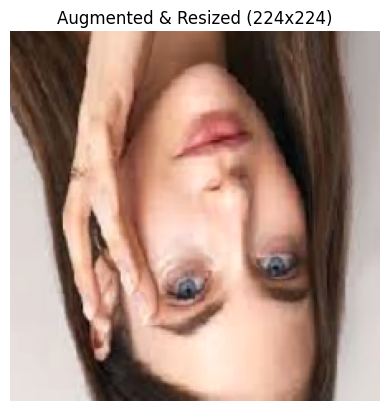

In [7]:
#For checking the augmented images
sample_batch = next(train_generator)
sample_img = sample_batch[0][0]  # first image in batch
plt.imshow(sample_img)
plt.title("Augmented & Resized (224x224)")
plt.axis("off")
plt.show()

Module 3 : Model Training and Evaluation

In [8]:
#Since EfficientNetB0 is not giving good accuracy so we are first trying few pre-trained models and check their accuracy
#Best among them will be our final model to go further
def comparing_pretrained_model(model_name,input_shape=(224,224,3),num_classes=10,dropout_rate=0.3):
    base_model=None

    if model_name== "ResNet50":
        base_model = ResNet50(weights="imagenet",include_top=False,input_shape=input_shape)
    elif model_name == "DenseNet121":
        base_model = DenseNet121(weights="imagenet",include_top=False,input_shape=input_shape)
    elif model_name == "VGG16":
        base_model = VGG16(weights="imagenet",include_top=False , input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = InceptionV3(weights="imagenet",include_top=False , input_shape=input_shape)
    elif model_name == "MobileNetV2":
        base_model = MobileNetV2(weights="imagenet",include_top=False,input_shape=input_shape)
    elif model_name == "EfficientNetV2B0":
        base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported model_name. Choose from the listed pretrained models.")


    #freeze base model initially
    base_model.trainable=False

    #Custom classification head
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dropout(dropout_rate)(x)
    predictions = Dense(num_classes,activation="softmax")(x)

    model = Model(inputs=base_model.input,outputs=predictions)


    #Compile model
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [9]:
#Creating a loop to try all the six pretrained models on the dataset

# List of pretrained models to try
pretrained_models = ["ResNet50", "DenseNet121", "VGG16", "InceptionV3", "MobileNetV2", "EfficientNetV2B0"]

# Dictionary to store results
results = {}

# Number of classes in your dataset
num_classes = len(train_generator.class_indices)

# Define callbacks for stability
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
]

print("🔍 Starting model comparison (5 epochs each)...\n")

# Loop through each pretrained model
for model_name in pretrained_models:
    print(f"🚀 Training {model_name} ...")

    # Build the model
    model = comparing_pretrained_model(model_name, input_shape=(224,224,3), num_classes=num_classes)

    # Train for few epochs
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,               # Short run for comparison
        callbacks=callbacks,    # Add callbacks here
        verbose=1
    )

    # Track the best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    results[model_name] = best_val_acc

    print(f"✅ {model_name}: Best Validation Accuracy = {best_val_acc:.4f}\n")

print("\n===== 🧠 Model Comparison Results =====")
for model_name, val_acc in results.items():
    print(f"{model_name}: {val_acc:.4f}")

# Identify the best model
best_model_name = max(results, key=results.get)
print(f"\n🏆 Best Model: {best_model_name} (Validation Accuracy = {results[best_model_name]:.4f})")


🔍 Starting model comparison (5 epochs each)...

🚀 Training ResNet50 ...


C:\Users\lenovo\PakhiSharma_AI_DermalScan\tf_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 3/10 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2795 - loss: 1.5619

C:\Users\lenovo\PakhiSharma_AI_DermalScan\tf_env\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.2499 - loss: 1.5710 - val_accuracy: 0.2152 - val_loss: 1.4409 - learning_rate: 0.0010
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3032 - loss: 1.4889 - val_accuracy: 0.1772 - val_loss: 1.4863 - learning_rate: 0.0010
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1962 - loss: 1.4617 - val_accuracy: 0.2785 - val_loss: 1.3611 - learning_rate: 0.0010
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2750 - loss: 1.4219 - val_accuracy: 0.2025 - val_loss: 1.4103 - learning_rate: 0.0010
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2401 - loss: 1.4889
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2440 - loss: 1.4847 - val_accuracy: 0.3038 - val_loss: 1.3804 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
✅ ResNet50: Best Validation Accuracy = 0.3038

🚀 Training 

In [15]:

# Get the best model name from the comparison step
print(f"\n🏁 Proceeding to full training using the best model: {best_model_name}")

# Build the best model again
final_model = comparing_pretrained_model(best_model_name, input_shape=(224,224,3), num_classes=num_classes)

checkpointpath = f"{best_model_name}_best_model.h5"

# Define callbacks for full training
final_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpointpath, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# Train the best model on the full dataset
final_history = final_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,                # Full training
    callbacks=final_callbacks,
    verbose=1
)

print("\n✅ Final training completed successfully!")




🏁 Proceeding to full training using the best model: MobileNetV2
Epoch 1/50


C:\Users\lenovo\PakhiSharma_AI_DermalScan\tf_env\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2897 - loss: 1.9027  
Epoch 1: val_accuracy improved from -inf to 0.35443, saving model to MobileNetV2_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2914 - loss: 1.8887 - val_accuracy: 0.3544 - val_loss: 1.4181 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.4193 - loss: 1.3463
Epoch 2: val_accuracy improved from 0.35443 to 0.55696, saving model to MobileNetV2_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4232 - loss: 1.3399 - val_accuracy: 0.5570 - val_loss: 1.1166 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.5950 - loss: 1.0673
Epoch 3: val_accuracy improved from 0.55696 to 0.67089, saving model to MobileNetV2_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5966 - loss: 1.0640 - val_accuracy: 0.6709 - val_loss: 0.8271 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.6024 - loss: 0.9680
Epoch 4: val_accuracy improved from 0.67089 to 0.73418, saving model to MobileNetV2_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6046 - loss: 0.9647 - val_accuracy: 0.7342 - val_loss: 0.7555 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.7119 - loss: 0.8042
Epoch 5: val_accuracy did not improve from 0.73418
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7106 - loss: 0.8031 - val_accuracy: 0.6329 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7243 - loss: 0.7388
Epoch 6: val_accuracy improved from 0.73418 to 0.74684, saving model to MobileNetV2_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7245 - loss: 0.7405 - val_accuracy: 0.7468 - val_loss: 0.6262 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.7355 - loss: 0.6808
Epoch 7: val_accuracy improved from 0.74684 to 0.86076, saving model to MobileNetV2_best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7358 - loss: 0.6827 - val_accuracy: 0.8608 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7867 - loss: 0.6526
Epoch 8: val_accuracy did not improve from 0.86076
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7858 - loss: 0.6571 - val_accuracy: 0.7468 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.7885 - loss: 0.5520
Epoch 9: val_accuracy did not improve from 0.86076
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7883 - loss: 0.5564 - val_accuracy: 0.7848 - val_loss: 0.6368 - learning_rate: 0.0010
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.7660 - loss: 0.6489
Epoch 10: val_accuracy improved from 0.86076 to 0.87342, saving model to MobileNetV2_best_model.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7667 - loss: 0.6462 - val_accuracy: 0.8734 - val_loss: 0.5327 - learning_rate: 0.0010
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.8194 - loss: 0.5280
Epoch 11: val_accuracy did not improve from 0.87342
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8161 - loss: 0.5334 - val_accuracy: 0.8608 - val_loss: 0.5463 - learning_rate: 3.0000e-04
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.8109 - loss: 0.5876
Epoch 12: val_accuracy did not improve from 0.87342
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8107 - loss: 0.5863 - val_accuracy: 0.7722 - val_loss: 0.6032 - learning_rate: 3.0000e-04
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.7644 - loss: 0.5903
Epoch 13: val_accuracy did not improve from 0.87342

Epoch 13: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
10

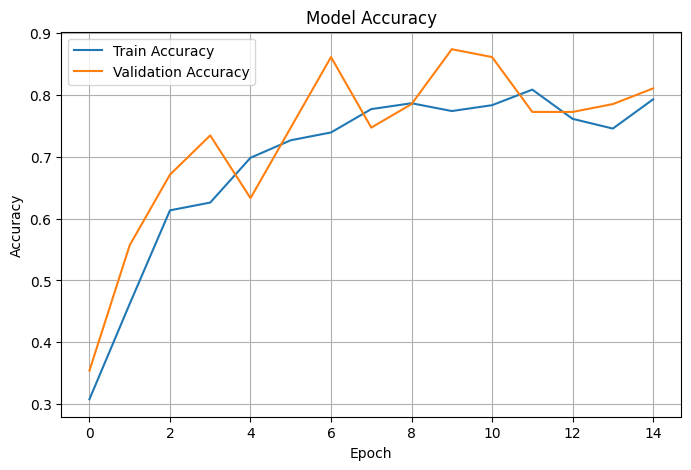

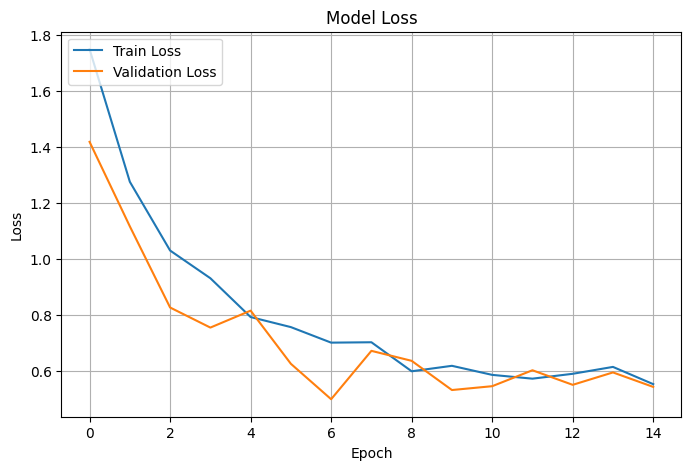

In [16]:
# ✅ Plot training vs validation accuracy
plt.figure(figsize=(8,5))
plt.plot(final_history.history['accuracy'], label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# ✅ Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(final_history.history['loss'], label='Train Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [17]:
# Get validation data and labels
val_generator.reset()  # ensure generator starts from beginning
preds = final_model.predict(val_generator, verbose=1)

# Predicted class indices
y_pred = np.argmax(preds, axis=1)

# True class indices
y_true = val_generator.classes


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step  


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: get class labels
class_labels = list(val_generator.class_indices.keys())


<Figure size 1000x1000 with 0 Axes>

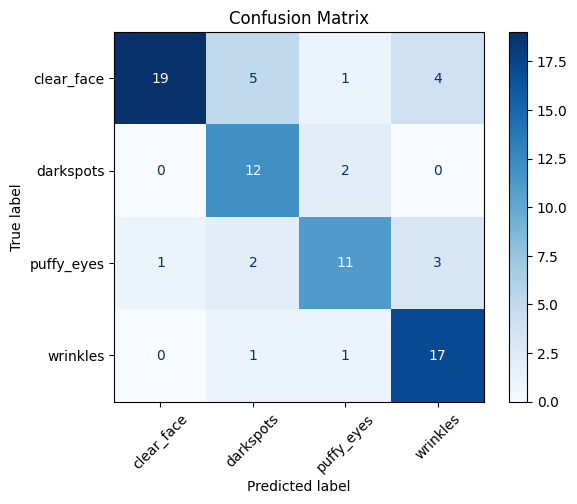

In [19]:
# Using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Module 4: Face Detection and Prediction Pipeline

In [20]:
#Load Model
model = load_model("MobileNetV2_best_model.h5")
#Classes from your dataset
class_labels = ['puffy_eyes', 'darkspots','clear_face','wrinkles']

#Load Haar Cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randint

def detect_predict_face(image_path, model, class_labels, target_size=(224, 224)):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Error: Could not read image.")
        return

    img_resized = cv2.resize(img,(800,800))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_h, img_w, _ = img_rgb.shape

    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.05, minNeighbors=3, minSize=(30, 30)
    )

    if len(faces) == 0:
        print("⚠️ No faces detected!")
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()
        return

    for (x, y, w, h) in faces:
        # Crop and preprocess the detected face
        face_roi = img_rgb[y:y+h, x:x+w]
        face_resized = cv2.resize(face_roi, target_size)
        face_array = np.expand_dims(face_resized / 255.0, axis=0)

        # Predict dermal condition
        preds = model.predict(face_array, verbose=0)[0]
        class_idx = np.argmax(preds)
        confidence = preds[class_idx] * 100
        predicted_class = class_labels[class_idx]

        # Estimate age range based on prediction
        if predicted_class.lower() == "clear_face":
            est_age = randint(18, 30)
        elif predicted_class.lower() == "darkspots":
            est_age = randint(30, 40)
        elif predicted_class.lower() == "puffy_eyes":
            est_age = randint(40, 55)
        else:
            est_age = randint(55, 70)

        # Build label text
        label = f"{predicted_class}: {confidence:.1f}% | Age: {est_age}"

        # Draw bounding box
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Dynamically set text scale & thickness
        font_scale = max(0.4, min(w / 250, 1.0))
        thickness = max(1, int(w / 200))
        (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

        # --- Position label ---
        # Try above box first
        text_y = y - 10
        # If above box goes outside, put below box
        if text_y - text_h < 0:
            text_y = y + h + text_h + 10
        # If below box goes beyond image bottom, adjust back upward
        if text_y > img_h - 5:
            text_y = img_h - 10

        # Clamp text_x within image width
        text_x = np.clip(x, 5, img_w - text_w - 5)

        # --- Draw filled rectangle for label background ---
        bg_top = max(0, text_y - text_h - 5)
        bg_bottom = min(img_h, text_y + 5)
        bg_left = max(0, text_x - 2)
        bg_right = min(img_w, text_x + text_w + 5)

        cv2.rectangle(img_rgb, (bg_left, bg_top), (bg_right, bg_bottom), (0, 255, 0), -1)

        # --- Draw label text ---
        cv2.putText(
            img_rgb,
            label,
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (0, 0, 0),
            thickness,
            cv2.LINE_AA,
        )

    # Display final output
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
()

()

⚠️ No faces detected!


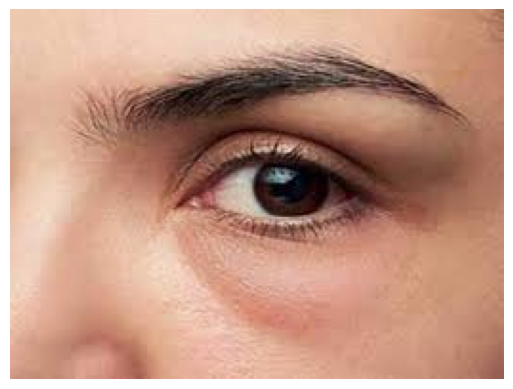

In [79]:
image_paths = df['files'].tolist()

import random
sample_path = random.choice(df['files'].tolist())
detect_predict_face(sample_path, model, class_labels)
